# Data Analysis Interview Challenge

This is your chance to show us with creative and rigorous solutions! Please include your code at the end of your submission, or in a separate file. We also accept incomplete solutions.

## Part 1 - Exploratory data analysis

The attached `logins.json` file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the **underlying patterns of the demand**. Please **report/illustrate important features of the demand**, such as **daily cycle**s. If there are data quality issues, please report them.

Importing relevant packages:

In [1]:
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels as sm
import seaborn as sns
import pandas as pd
import numpy as np
import json

In [2]:
with open('logins.json') as json_file:
    data = json.load(json_file)

Converting *json file* in dataFrame:

In [3]:
df_login = json_normalize(data, 'login_time')
df_login.rename(columns={0: 'datetime'}, inplace=True)
df_login.head()

,datetime
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df_login['datetime'] = pd.to_datetime(df_login['datetime'])

Adding a `counter` column and resampling every 15 minutes:

In [5]:
df_login['counter'] = 1

In [6]:
df_login.set_index('datetime', inplace=True)

In [7]:
df_login_15 = pd.DataFrame(df_login['counter'].resample('15T').sum())

In [8]:
df_login_15.head()

,counter
datetime,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Inspecting earliest and latest date:

In [9]:
print ('Earliest  :', min(df_login_15.index))
print ('Latest    :', max(df_login_15.index))

Earliest  : 1970-01-01 20:00:00
Latest    : 1970-04-13 18:45:00


### Analyzing seasonality

Seasonality indicates us if some patterns are repeated within the same interval over time. Time Series have different features to analyze, as level (average value in the series), trends (is the value increasing or decreasing?), seasonality (short-terme cycles) and noise (random variation). According to an additive analysis, the Time Serie could be represented by the sum of those signals:

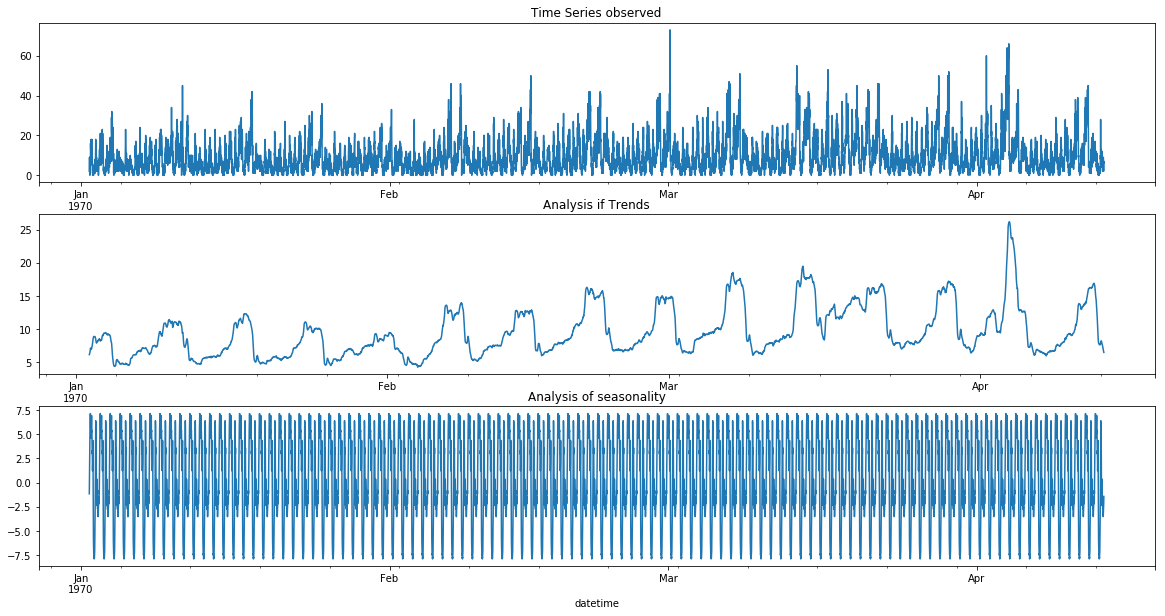

In [10]:
from statsmodels.tsa import seasonal
_ = plt.figure(figsize=(20,10))

_ = serie_analyse = sm.tsa.seasonal.seasonal_decompose(df_login_15.counter, model='additive', freq=96)
_ = plt.subplot(3,1,1)
_ = serie_analyse.observed.plot()
_ = plt.title('Time Series observed')
_ = plt.subplot(3,1,2)
_ = serie_analyse.trend.plot()
_ = plt.title('Analysis if Trends')
_ = plt.subplot(3,1,3)
_ = serie_analyse.seasonal.plot()
_ = plt.title('Analysis of seasonality')

We can note that the time series is the sum of a seasonality pattern (probably daily patterns) and a weekly trend to increase the logins in the second half of the period analyzed with respect to the first half. Now, let’s take a look to weekly and daily analysis:

Adding the following identificator columns:

1. `week_day` to identify day of the week, between 0 and 6
2. `day_year` to identify day of the year, between 1 and 256
3. `week_year` to identify week of the year, between 1 and 52
4. `hour_day`, between 0 and 23

In [11]:
df_login_15['week_day'] = df_login_15.index.dayofweek
df_login_15['day_year'] = df_login_15.index.day
df_login_15['week_year'] = df_login_15.index.week
df_login_15['hour_day'] = df_login_15.index.hour

In [12]:
df_login_15.head()

,counter,week_day,day_year,week_year,hour_day
datetime,,,,,
1970-01-01 20:00:00,2,3,1,1,20
1970-01-01 20:15:00,6,3,1,1,20
1970-01-01 20:30:00,9,3,1,1,20
1970-01-01 20:45:00,7,3,1,1,20
1970-01-01 21:00:00,1,3,1,1,21


#### Average logins/15 minutes per weekday:

Grouping by `week_year`, `week_day` and `hour_day` to observe the mean of logins every 15 minutes during each hour:

In [16]:
df_week_day = df_login_15.groupby(['week_year', 'week_day', 'hour_day']).mean()

In [17]:
df_week_day_index_reset = df_week_day.reset_index()

Grouping by `week_year`, and `week_day` to observe the mean of logins every 15 minutes during each day:

In [18]:
df_week_day_index_reset.groupby(['week_year', 'week_day']).mean().head()

hour_day   counter  day_year
week_year week_day                              
1         3             21.5  7.000000       1.0
          4             11.5  7.093750       2.0
          5             11.5  8.260417       3.0
          6             11.5  8.208333       4.0
2         0             11.5  4.781250       5.0

Now, the mean every `day_week` and the porcentual change with respect to the previous day:

In [19]:
df_mean_logins_weekday = df_week_day_index_reset.groupby(['week_year', 'week_day']).mean().groupby('week_day').mean()

In [20]:
df_mean_logins_weekday['pct_change'] = df_mean_logins_weekday.counter.pct_change()
df_mean_logins_weekday.fillna(0, inplace=True)

In [21]:
df_mean_logins_weekday

,hour_day,counter,day_year,pct_change
week_day,,,,
0,11.333333,6.199269,14.066667,0.000000
1,11.500000,6.895833,15.142857,0.112362
2,11.500000,7.692708,13.928571,0.115559
3,12.166667,8.694444,14.000000,0.130219
4,11.500000,10.561111,15.000000,0.214696
5,11.500000,13.456250,16.000000,0.274132
6,11.500000,12.615972,13.066667,-0.062445


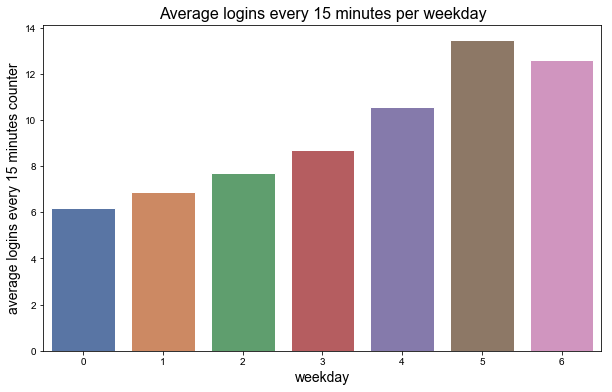

In [22]:
f, ax1 = plt.subplots(figsize=(10,6))
_ = sns.set(style="whitegrid")
_ = ax1 = sns.barplot(x=df_mean_logins_weekday.index,
                     y=df_mean_logins_weekday.counter)
_ = plt.title('Average logins every 15 minutes per weekday', fontsize=16)
_ = plt.xlabel('weekday', fontsize=14)
_ = plt.ylabel('average logins every 15 minutes counter', fontsize=14)

Observing the results and Figure below:

1. It's clear that weekends offer the higher rate logins/15 minutes, topping on Saturday, with a mean of 13.45 logins/15 min.
2. The logins rate changes slowly from Monday to Thursday, with increments between 11.2% and 13%
3. Porcentual increment in Thursday-Friday and Friday-Saturday represents a 21.4% and 27.4% respectively.
4. Logins rate decreases in 6.2% in Sunday respect to Saturday, but still being the second day with higher rate logins with 12.61 logins/15 min.

#### Logins average per weekday:

Grouping by `week_year`, `week_day` and `hour_day` to observe the mean of logins every day:

In [23]:
df_weekly = df_login_15.groupby(['week_year', 'week_day', 'hour_day']).sum()
df_weekly.head()

counter  day_year
week_year week_day hour_day                   
1         3        20             24         4
                   21              9         4
                   22             21         4
                   23             58         4
          4        0              53         8

In [24]:
df_weekly = df_weekly.reset_index()

In [25]:
df_weekly = df_weekly.groupby(['week_year', 'week_day']).mean().groupby('week_day').mean()

In [26]:
df_weekly['pct_change'] = df_weekly.counter.pct_change()
df_weekly.fillna(0, inplace=True)
df_weekly

,hour_day,counter,day_year,pct_change
week_day,,,,
0,11.333333,24.797076,56.266667,0.000000
1,11.500000,27.583333,60.571429,0.112362
2,11.500000,30.770833,55.714286,0.115559
3,12.166667,34.777778,56.000000,0.130219
4,11.500000,42.244444,60.000000,0.214696
5,11.500000,53.825000,64.000000,0.274132
6,11.500000,50.463889,52.266667,-0.062445


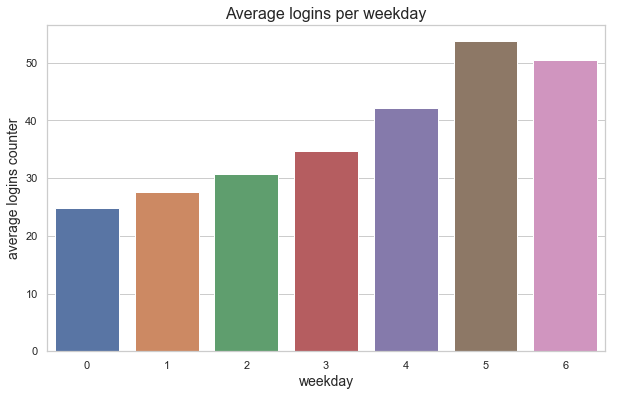

In [23]:
f, ax1 = plt.subplots(figsize=(10,6))
_ = sns.set(style="whitegrid")
_ = ax1 = sns.barplot(x=df_weekly.index,
                     y=df_weekly.counter)
_ = plt.title('Average logins per weekday', fontsize=16)
_ = plt.xlabel('weekday', fontsize=14)
_ = plt.ylabel('average logins counter', fontsize=14)

In this case, we get the average of logins every hour. For instances, the average logins/hour on Saturday is 53, followed by 50 on Sundays and 42 on Fridays. The porcentual change is the same that below. 

#### Profile of logins/15 minutes during a day

Grouping the logins/15 minutes for `hour_day`, `week_day` and `week_year` and then, the mean through every `hour_day`:

In [27]:
df_week_day_index_reset.head(10)

,week_year,week_day,hour_day,counter,day_year
0,1,3,20,6.00,1.0
1,1,3,21,2.25,1.0
2,1,3,22,5.25,1.0
3,1,3,23,14.50,1.0
4,1,4,0,13.25,2.0
5,1,4,1,8.25,2.0
6,1,4,2,10.75,2.0
7,1,4,3,7.00,2.0
8,1,4,4,2.25,2.0
9,1,4,5,2.75,2.0


In [28]:
df_mean_logins_hour = df_week_day_index_reset.groupby('hour_day').mean()

In [29]:
df_mean_logins_hour.head()

,week_year,week_day,counter,day_year
hour_day,,,,
0,8.352941,3.029412,14.688725,14.588235
1,8.352941,3.029412,15.482843,14.588235
2,8.352941,3.029412,14.215686,14.588235
3,8.352941,3.029412,11.840686,14.588235
4,8.352941,3.029412,12.338235,14.588235


Calculating, percentiles:

In [32]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [33]:
df_hour_profile = df_week_day_index_reset.loc[:, ['week_year' ,'week_day', 'hour_day', 'counter']]

In [34]:
df_hour_profile_summarize = df_hour_profile.groupby('hour_day').agg([np.mean, 
                                                                     percentile(n=25), 
                                                                     percentile(n=75), 
                                                                     np.min,
                                                                     np.max]).counter
df_hour_profile_summarize

,mean,percentile_25,percentile_75,amin,amax
hour_day,,,,,
0,14.688725,10.2500,18.0000,3.50,43.25
1,15.482843,8.7500,20.1875,4.00,59.25
2,14.215686,6.7500,22.0000,2.50,39.25
3,11.840686,4.0625,17.5000,1.00,38.25
4,12.338235,3.2500,19.3750,1.00,51.25
5,7.218137,1.7500,11.8750,0.50,56.50
6,2.789216,1.0000,4.1875,0.25,22.75
7,1.997549,1.2500,2.5000,0.50,9.50
8,2.004902,1.2500,2.5000,0.00,6.75


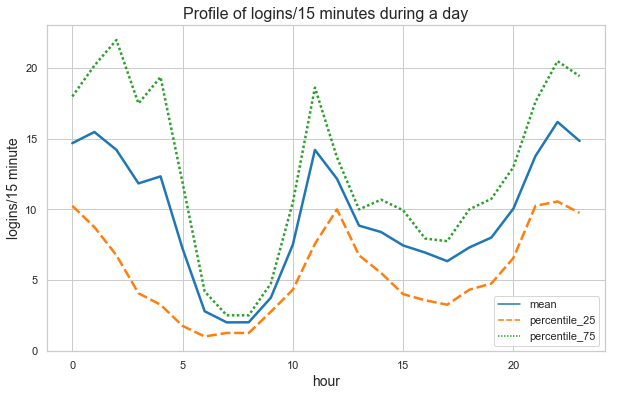

In [45]:
f, ax = plt.subplots(figsize=(10,6))
_ = sns.set(style="whitegrid")
_ = sns.lineplot(data=df_hour_profile_summarize.loc[:, ['mean', 
                                                    'percentile_25', 
                                                    'percentile_75']], 
                 palette="tab10", 
                 linewidth=2.5)
_ = plt.title('Profile of logins/15 minutes during a day', fontsize=16)
_ = plt.xlabel('hour', fontsize=14)
_ = plt.ylabel('logins/15 minute', fontsize=14)

Finally, the daily profile indicates that :
1. Between 21:00 and 4:00, the average keeps within 11.84 and 16.19 logins/hour
2. Maximum decline come about between 5:00-10:00, with 1.99 and 7.21 as tail and top values.
3. Second decline occurs in the hour range of 13:00 and 19:00, with a minimum average of 6.33 logins/hr
4. Between 11:00 and 12:00 pm there is another average top of 14.21 logins/hr.